**PASOS A SEGUIR PARA EL ANALISIS:** 

-Analisis de datos y preprocesado

-Entrenamiento de modelos

-Evaluación

**ANALISIS Y PREPROCESADO:**

Importaremos las librerias necesarias y cargaremos los ficheros. Como vamos a trabajar la X y la Y por separado, de momento no combinamos los dataframes. Justo antes de entrenar ya aplicamos el metodo merge() para asegurarnos de que cada muestra va con su etiqueta de clase.

No hemos realizado escalado de datos ni normalización ya que vamos a trabajar con modelos basados en arboles, por lo que la escala de los datos no afecta a la capacidad de clasificación. Asimismo, tampoco hemos aplicado tramificación de las variables ya que esto limita la capacidad del árbol para seleccionar el punto de split.

Creamos una nueva variable llamada age siendo esta la resta del año de construcción menos el data recorded. Hay que hacer una modifición al año de construcción para que se pueda realizar la operación.

Hay ciertas variables que tienen un amplio número de valores, por lo que calcularemos su frecuencia relativa. Nos quedaremos con aquellas con una mayor representación y el resto las catalogaremos como 'Rare'.

Identificamos y rellenamos los valores de aquellas variable con missings. En las variables numericas, asignamos la media. En las variables categoricas, asignmos la moda.

In [52]:
#Importamos todas las librerias que utilizaremos:

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import OrdinalEncoder
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import FunctionTransformer
from sklearn import preprocessing
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [53]:
#Cargamos el fichero de Trainign de X:

trainingX= pd.read_csv('Training set values, X.csv')

In [54]:
#Podemos ver que los datos se han cargado correctamente:

trainingX.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


In [55]:
trainingX.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 40 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59400 non-null  int64  
 1   amount_tsh             59400 non-null  float64
 2   date_recorded          59400 non-null  object 
 3   funder                 55763 non-null  object 
 4   gps_height             59400 non-null  int64  
 5   installer              55745 non-null  object 
 6   longitude              59400 non-null  float64
 7   latitude               59400 non-null  float64
 8   wpt_name               59398 non-null  object 
 9   num_private            59400 non-null  int64  
 10  basin                  59400 non-null  object 
 11  subvillage             59029 non-null  object 
 12  region                 59400 non-null  object 
 13  region_code            59400 non-null  int64  
 14  district_code          59400 non-null  int64  
 15  lg

In [56]:
#Como el date_recorded es una variable string lo conviertimos a entero. Para ello primero reemplazo el  guión '-' por un espacio vacio ''
#y después la transformamos a entero. Para no tener dos variables, eliminamos la variable data_recoded y guardamos la variable 
#transformada en entero en data_recorded.

trainingX['date_numeric'] =(trainingX['date_recorded']).str.replace('-','')
trainingX['date_numeric'] =trainingX['date_numeric'].astype(int)
trainingX = trainingX.drop(["date_recorded"],axis= 1)

#Asimismo, calculamos la edad de los pozos. Esto lo realizamos restando el año de construcción menos el date_numeric creado antes. Como el año de
#de construcción no contiene mes ni dia, lo multiplicamos por 1000 para que ambos esten en la misma unidad.

trainingX['age']= trainingX['date_numeric'] - trainingX['construction_year'] * 10000

#Cuando el año de construcción no tiene una fecha, lo ponemos a 0.

trainingX['age']= np.where(trainingX["construction_year"] == 0, 0, trainingX["age"])
trainingX['age'].head(15)

0     120314
1      30306
2      40225
3     270128
4          0
5      20313
6          0
7          0
8          0
9          0
10       220
11    260218
12         0
13     40315
14         0
Name: age, dtype: int64

In [57]:
#Creamos una variable nueva donde agruparemos todas las variables que son categoricas del dataframe.

categorical_columns = ['extraction_type', 'management', 'water_quality' , 'quality_group', 'quantity','quantity_group', 
          'source','source_class', 'waterpoint_type','waterpoint_type_group', 'extraction_type_group',
                       'extraction_type_class','management_group','payment','payment_type', 'source_type','basin','region', 'lga', 'public_meeting',
                      'scheme_management','subvillage', 'installer', 'funder'] 

In [58]:
#Cargamos el fichero Training Y.

trainingY= pd.read_csv('Training set labels, Y.csv')

#Como una libreria de nuestro modelo requeria que la etiqueta fuese numerica, reemplazamos los valores de Training Y por 0, 1 y 2.

trainingY.replace(['functional','functional needs repair','non functional'], [0, 1, 2], inplace= True) 
#inplace= True sobreescribe en cambio automaticamente
trainingY

C:\Users\Aisha Aman\AppData\Local\Temp\ipykernel_12660\122114172.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  trainingY.replace(['functional','functional needs repair','non functional'], [0, 1, 2], inplace= True)


,id,status_group
0,69572,0
1,8776,0
2,34310,0
3,67743,2
4,19728,0
...,...,...
59395,60739,0
59396,27263,0
59397,37057,0
59398,31282,0


In [59]:
#Cargamos y abrimos Test X:

testX= pd.read_csv('Test set values, X  test.csv')
testX.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,50785,0.0,2013-02-04,Dmdd,1996,DMDD,35.290799,-4.059696,Dinamu Secondary School,0,...,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,other,other
1,51630,0.0,2013-02-04,Government Of Tanzania,1569,DWE,36.656709,-3.309214,Kimnyak,0,...,never pay,soft,good,insufficient,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe
2,17168,0.0,2013-02-01,NaN,1567,NaN,34.767863,-5.004344,Puma Secondary,0,...,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,other,other
3,45559,0.0,2013-01-22,Finn Water,267,FINN WATER,38.058046,-9.418672,Kwa Mzee Pange,0,...,unknown,soft,good,dry,dry,shallow well,shallow well,groundwater,other,other
4,49871,500.0,2013-03-27,Bruder,1260,BRUDER,35.006123,-10.950412,Kwa Mzee Turuka,0,...,monthly,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe


In [60]:
#Repetimos el mismo proceso que hemos hecho con Training X, pero con Test X:

testX['date_numeric'] =(testX['date_recorded']).str.replace('-','')
testX['date_numeric'] =testX['date_numeric'].astype(int)
testX = testX.drop(["date_recorded"], axis= 1)
testX['age']= testX['date_numeric'] - testX['construction_year'] * 10000
testX['age']= np.where(testX["construction_year"] == 0, 0, testX["age"])
testX.head()

testX

,id,amount_tsh,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,...,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,date_numeric,age
0,50785,0.0,Dmdd,1996,DMDD,35.290799,-4.059696,Dinamu Secondary School,0,Internal,...,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,other,other,20130204,10204
1,51630,0.0,Government Of Tanzania,1569,DWE,36.656709,-3.309214,Kimnyak,0,Pangani,...,good,insufficient,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe,20130204,130204
2,17168,0.0,NaN,1567,NaN,34.767863,-5.004344,Puma Secondary,0,Internal,...,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,other,other,20130201,30201
3,45559,0.0,Finn Water,267,FINN WATER,38.058046,-9.418672,Kwa Mzee Pange,0,Ruvuma / Southern Coast,...,good,dry,dry,shallow well,shallow well,groundwater,other,other,20130122,260122
4,49871,500.0,Bruder,1260,BRUDER,35.006123,-10.950412,Kwa Mzee Turuka,0,Ruvuma / Southern Coast,...,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,20130327,130327
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14845,39307,0.0,Danida,34,Da,38.852669,-6.582841,Kwambwezi,0,Wami / Ruvu,...,good,enough,enough,river,river/lake,surface,communal standpipe,communal standpipe,20110224,230224
14846,18990,1000.0,Hiap,0,HIAP,37.451633,-5.350428,Bonde La Mkondoa,0,Pangani,...,salty,insufficient,insufficient,shallow well,shallow well,groundwater,hand pump,hand pump,20110321,170321
14847,28749,0.0,NaN,1476,NaN,34.739804,-4.585587,Bwawani,0,Internal,...,good,insufficient,insufficient,dam,dam,surface,communal standpipe,communal standpipe,20130304,30304
14848,33492,0.0,Germany,998,DWE,35.432732,-10.584159,Kwa John,0,Lake Nyasa,...,good,insufficient,insufficient,river,river/lake,surface,communal standpipe,communal standpipe,20130218,40218


In [61]:
testX.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14850 entries, 0 to 14849
Data columns (total 41 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     14850 non-null  int64  
 1   amount_tsh             14850 non-null  float64
 2   funder                 13980 non-null  object 
 3   gps_height             14850 non-null  int64  
 4   installer              13973 non-null  object 
 5   longitude              14850 non-null  float64
 6   latitude               14850 non-null  float64
 7   wpt_name               14850 non-null  object 
 8   num_private            14850 non-null  int64  
 9   basin                  14850 non-null  object 
 10  subvillage             14751 non-null  object 
 11  region                 14850 non-null  object 
 12  region_code            14850 non-null  int64  
 13  district_code          14850 non-null  int64  
 14  lga                    14850 non-null  object 
 15  wa

In [62]:
#Observando los resultados del Training Y, a simple vista podemos ver que disponemos de menos información sobre funcionanl needs repair (1),
#por lo que sera mas difícil de predecir.

trainingY['status_group'].value_counts()

status_group
0    32259
2    22824
1     4317
Name: count, dtype: int64

In [63]:
#Creamos la variable columnas en la que agruparemos todas las columnas numericas de nuestro dataframe. Y después agrupamos
#las variables categoricas y numericas en joined_list.

columnas = ['amount_tsh', 'gps_height', 'longitude', 'latitude','date_numeric', 'construction_year', 'population', 'district_code', 'age']
joined_list = columnas + categorical_columns


In [64]:
#Observamos valores maximo y minimo de las variables para comprobar que no haya ningún valor extremo que haya que corregir:
trainingX[columnas].describe()

,amount_tsh,gps_height,longitude,latitude,date_numeric,construction_year,population,district_code,age
count,59400.000000,59400.000000,59400.000000,5.940000e+04,5.940000e+04,59400.000000,59400.000000,59400.000000,59400.000000
mean,317.650385,668.297239,34.077427,-5.706033e+00,2.011967e+07,1300.652475,179.909983,5.629747,100244.583586
std,2997.574558,693.116350,6.567432,2.946019e+00,9.499218e+03,951.620547,471.482176,9.633649,124673.233240
min,0.000000,-90.000000,0.000000,-1.164944e+01,2.002101e+07,0.000000,0.000000,0.000000,-69399.000000
25%,0.000000,0.000000,33.090347,-8.540621e+00,2.011040e+07,0.000000,0.000000,2.000000,0.000000
50%,0.000000,369.000000,34.908743,-5.021597e+00,2.012101e+07,1986.000000,25.000000,3.000000,40315.000000
75%,20.000000,1319.250000,37.178387,-3.326156e+00,2.013021e+07,2004.000000,215.000000,5.000000,160330.000000
max,350000.000000,2770.000000,40.345193,-2.000000e-08,2.013120e+07,2013.000000,30500.000000,80.000000,530330.000000


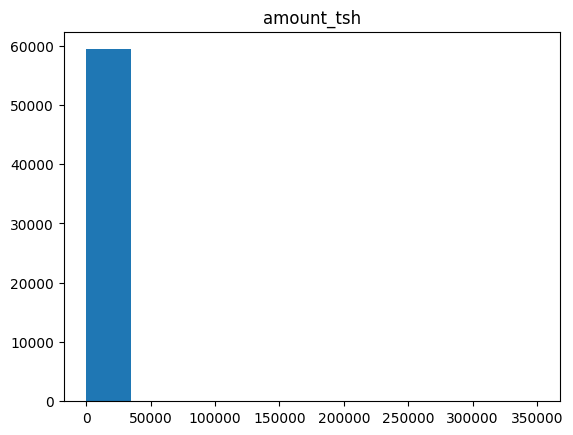

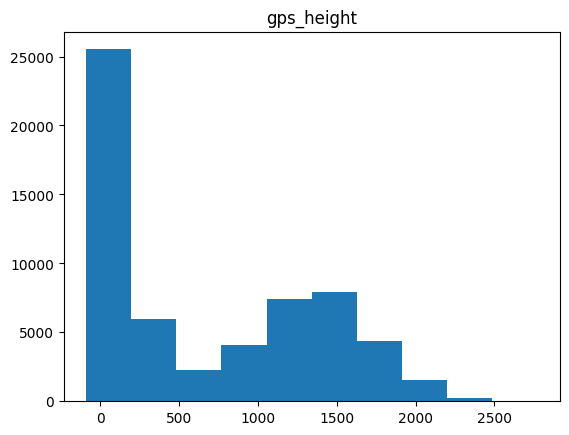

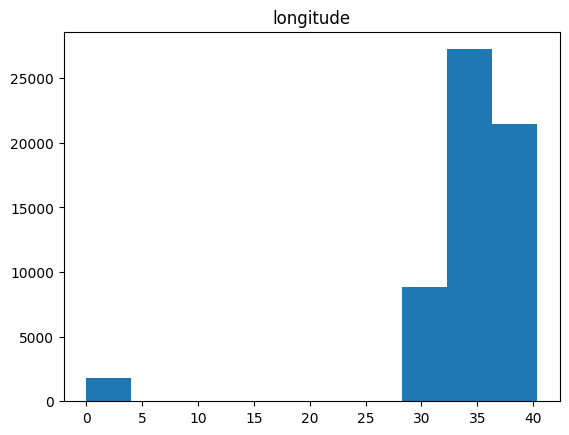

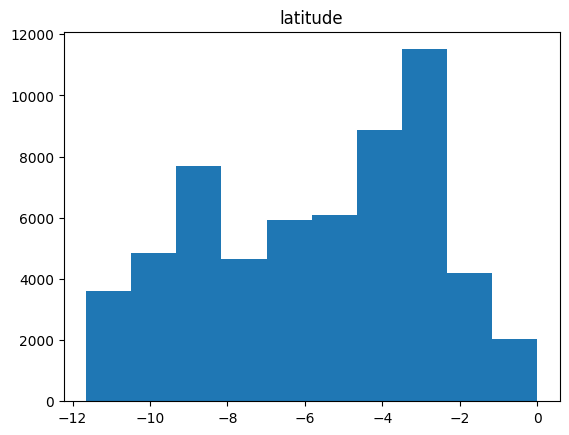

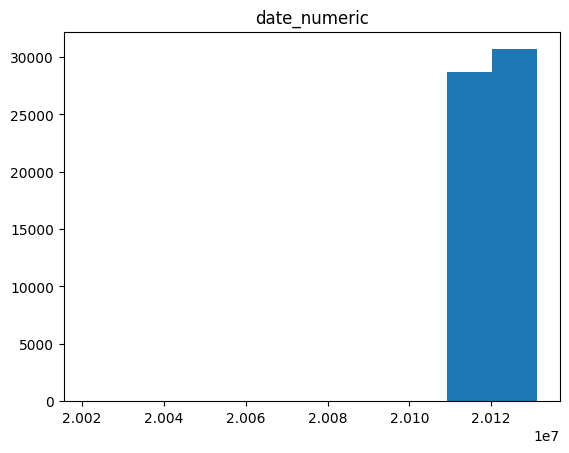

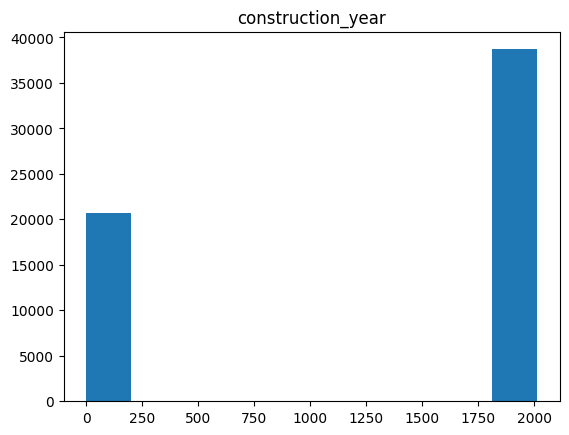

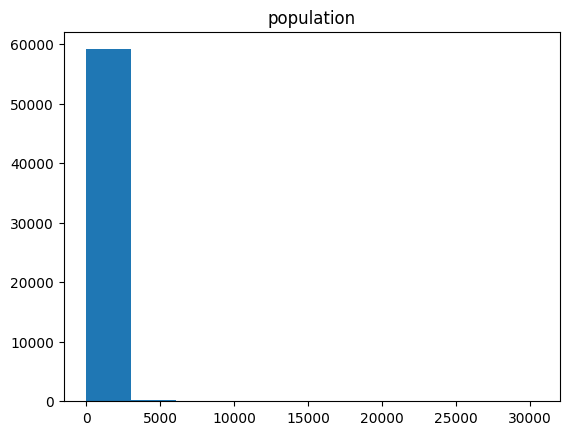

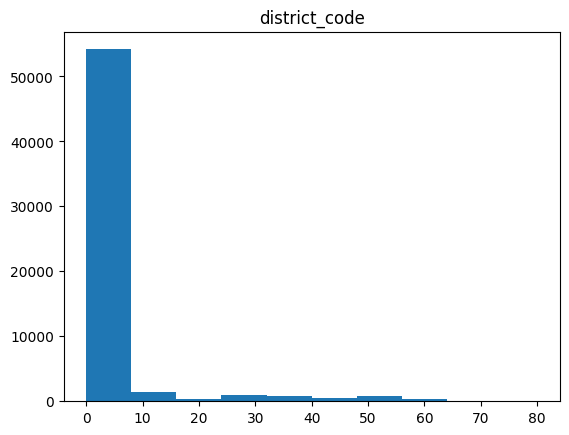

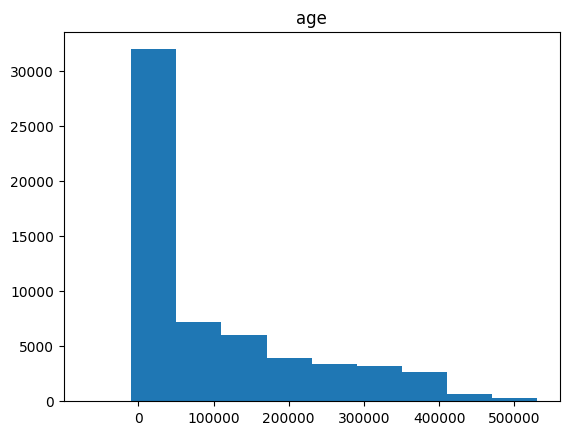

In [65]:
for l in columnas:
    plt.hist(trainingX[l])
    plt.title(l)
    plt.show()

In [66]:
#Estas variables tienen un amplio número de valores, por lo que calculamos la frecuencia relativa de cada valor. Así podemos 
#observar aquellos valores con mayor frecuencia.

freqs = trainingX['subvillage'].value_counts(normalize=True)
freqs2 = trainingX['installer'].value_counts(normalize=True)
freqs3 = trainingX['ward'].value_counts(normalize=True)
freqs4 = trainingX['scheme_name'].value_counts(normalize=True)
freqs5 = trainingX['funder'].value_counts(normalize=True)
freqs5

funder
Government Of Tanzania    0.162904
Danida                    0.055843
Hesawa                    0.039489
Rwssp                     0.024640
World Bank                0.024192
                            ...   
Muwasa                    0.000018
Msigw                     0.000018
Rc Mofu                   0.000018
Overland High School      0.000018
Samlo                     0.000018
Name: proportion, Length: 1896, dtype: float64

In [67]:
#A continuación,nos quedaremos con los valores de las variables que tengan una frecuencia mayor que la seleccionada.

frequent_cat = [ x for x in freqs.loc[freqs > 0.002].index.values]
frequent_cat2 = [ x for x in freqs2.loc[freqs2 > 0.005].index.values]
frequent_cat3 = [ x for x in freqs3.loc[freqs3 > 0.002].index.values]
frequent_cat4 = [ x for x in freqs4.loc[freqs4 > 0.005].index.values]
frequent_cat5 = [ x for x in freqs5.loc[freqs5 > 0.005].index.values]
frequent_cat5

['Government Of Tanzania',
 'Danida',
 'Hesawa',
 'Rwssp',
 'World Bank',
 'Kkkt',
 'World Vision',
 'Unicef',
 'Tasaf',
 'District Council',
 'Dhv',
 'Private Individual',
 'Dwsp',
 '0',
 'Norad',
 'Germany Republi',
 'Tcrs',
 'Ministry Of Water',
 'Water',
 'Dwe',
 'Netherlands',
 'Hifab',
 'Adb',
 'Lga',
 'Amref',
 'Fini Water',
 'Oxfam',
 'Wateraid',
 'Rc Church',
 'Isf',
 'Rudep',
 'Mission',
 'Private',
 'Jaica']

In [68]:
#Todos aquellos valores que no hayan sido agrupados anteriormente (mayor frecuencia), los catalogamos como 'Rare'.

trainingX['subvillage'] = np.where(trainingX['subvillage'].isin(frequent_cat), trainingX['subvillage'], "Rare")
testX['subvillage'] = np.where(testX['subvillage'].isin(frequent_cat), testX['subvillage'], "Rare")

trainingX['installer'] = np.where(trainingX['installer'].isin(frequent_cat2), trainingX['installer'], "Rare")
testX['installer'] = np.where(testX['installer'].isin(frequent_cat2), testX['installer'], "Rare")

trainingX['ward'] = np.where(trainingX['ward'].isin(frequent_cat3), trainingX['ward'], "Rare")
testX['ward'] = np.where(testX['ward'].isin(frequent_cat3), testX['ward'], "Rare")

trainingX['scheme_name'] = np.where(trainingX['scheme_name'].isin(frequent_cat4), trainingX['scheme_name'], "Rare")
testX['scheme_name'] = np.where(testX['scheme_name'].isin(frequent_cat4), testX['scheme_name'], "Rare")

trainingX['funder'] = np.where(trainingX['funder'].isin(frequent_cat5), trainingX['funder'], "Rare")
testX['funder'] = np.where(testX['funder'].isin(frequent_cat5), testX['funder'], "Rare")


In [69]:
#En este ejemplo de la variable Funder,  vemos que un 41% son Rare, como hemos asignado anteriormente.

trainingX['funder'].value_counts(normalize=True)

funder
Rare                      0.419949
Government Of Tanzania    0.152929
Danida                    0.052424
Hesawa                    0.037071
Rwssp                     0.023131
World Bank                0.022710
Kkkt                      0.021667
World Vision              0.020976
Unicef                    0.017795
Tasaf                     0.014764
District Council          0.014192
Dhv                       0.013956
Private Individual        0.013906
Dwsp                      0.013653
0                         0.013081
Norad                     0.012879
Germany Republi           0.010269
Tcrs                      0.010135
Ministry Of Water         0.009933
Water                     0.009815
Dwe                       0.008148
Netherlands               0.007912
Hifab                     0.007576
Adb                       0.007542
Lga                       0.007441
Amref                     0.007155
Fini Water                0.006616
Oxfam                     0.006044
Wateraid     

In [70]:
#En esta linea del codigo, transformamos el tipo de las variables a 'category' (tanto en train como test) para que el 
#modelo pueda entrenar con las variables categoricas.
for c in categorical_columns:
    trainingX[c] = trainingX[c].astype('category')
    testX[c] = testX[c].astype('category')


In [71]:
#Podemos observar que tenemos una lista de variables con valor nulo. Sumamos y agrupamos de manera ascendente por número de 
#valores nulos que tiene cada variable, por ejemplo vemos que scheme_name tiene 28.810 valores nulos.

trainingX.isnull().sum().sort_values(ascending = False)

scheme_management        3878
public_meeting           3334
permit                   3056
wpt_name                    2
water_quality               0
extraction_type_group       0
extraction_type_class       0
management                  0
management_group            0
payment                     0
payment_type                0
id                          0
extraction_type             0
quantity                    0
quantity_group              0
source                      0
source_type                 0
source_class                0
waterpoint_type             0
waterpoint_type_group       0
date_numeric                0
quality_group               0
scheme_name                 0
construction_year           0
amount_tsh                  0
funder                      0
gps_height                  0
installer                   0
longitude                   0
latitude                    0
num_private                 0
basin                       0
subvillage                  0
region    

In [72]:
#Aqui transformamos las variables del train y test con valor 0 por la media de cada columna numerica.
for i in columnas:
    mediatrain= trainingX[i].mean()
    mediatest= testX[i].mean()
    trainingX[i]= trainingX[i].replace(to_replace=0.0, value=mediatrain, inplace=False)
    testX[i]=  testX[i].replace(to_replace=0.0, value=mediatest, inplace=False)
    

In [73]:
#Aqui transformamos las variables del train y test con valor nulo por la moda de cada columna categorica.
for i in categorical_columns:
    mediantrain= trainingX[i].mode()
    mediantest= testX[i].mode()
    trainingX[i]= trainingX[i].fillna(value=mediantrain[0], inplace=False)
    testX[i]=  testX[i].fillna(value=mediantest[0], inplace=False)

**ENTRENAMIENTO DE MODELOS:**

Entrenamos el modelo con un 80% del train y evaluamos con el 20% restante. El entrenamiento lo realizamos con 3 modelos distintos, ajustando los hiperparametros para obtener una mayor puntuación. El listado completo de configuraciones utilizadas está disponible al final del notebook.

Definimos nuestro modelo final compuesto por los 3 anteriores modelos. Con el VotingClassifier hacemos que la decisión tomada sea aquella mas votada por los 3 modelos.

In [74]:
#Hacemos un merge en id para asegurarnos que cada muestra esta con la etiqueta correcta:
merged_pd = pd.merge(trainingX, trainingY, on="id")
trainingX = merged_pd[joined_list]
trainingY = merged_pd['status_group']

#En esta primera parte definimos con que porcentaje realizamos el train:
train80_X, dev_X, train80_Y, dev_Y = train_test_split(trainingX,trainingY, test_size=0.2, random_state=1)

#Vamos a probar 3 modelos: GradientBoosting con sklearn, GradientBoosting con la libreria XGBoost y un RandomForest.
#Hemos probado otros hiperparametros pero estos son los que mejor han funcionado. Escogemos n_iter_no_change= 30, porque 
#el entrenamiento se detiene cuando lleva 30 iteraciones sin mejorar el score, asi evitamos el sobreajuste.

clf1 = HistGradientBoostingClassifier(categorical_features=categorical_columns, verbose=False, max_iter=600,n_iter_no_change=30, max_depth=None,
                                    validation_fraction=0.1, random_state=1)

clf2 = XGBClassifier(n_estimators=350,objective='multi:softprob',random_state=55,tree_method="hist", enable_categorical=True, n_jobs=4)

#El RandomForest no puede trabajar directamente con categoricas, tenemos que ponerle un OneHotEncoder antes para convertirlas en dummies. 
#Las variables númericas no sufren ninguna transformación.

transfomer = make_column_transformer((FunctionTransformer(lambda x: x), columnas), (OneHotEncoder(), categorical_columns))


clf3 = make_pipeline(transfomer, RandomForestClassifier(random_state=55,verbose=True, n_estimators=100,
                                                        max_depth=23,min_samples_leaf=5, max_features=35, n_jobs=2))

#Nuestro modelo definitivo combina las predicciones de los 3 modelos, escogiendo la decisión más votada por los 3 modelos.

clf = VotingClassifier(estimators=[('skgb', clf1), ('xgb', clf2), ('rf', clf3)], voting='soft') 

clf.fit(train80_X,train80_Y) # Entreno con el 80%
clf.score(dev_X, dev_Y) # Evaluo con el 20% restante

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   42.6s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:  1.5min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.2s finished


0.8151515151515152

**EVALUACIÓN:**

Cuando tenemos modelo definitivo, realizamos un analisis mas en profundidad de su funcionamiento con un classification report y la Matriz de confusión.
Habiendo obtenido una buena puntuación, ahora entrenamos el modelo utilizando todo el conjunto de entrenamiento.
Realizamos nuestra predicción, hacemos los cambios necesarios de las etiquetas de las muestras y lo guardamos en un csv para subirlo a la web de la competición.

Con el classification report, podemos observar que tan bien ha sido capaz nuestro modelo de predecir. El modelo lo hace claramente mejor prediciendo la clases 0 (functional) y 2 (non functional) que la clase 2 (functional needs repair). Una hipotesis es que esto se debe a que habia muchos menos muestras de la clase 1 disponibles para el entrenamiento, y por tanto el modelo no ha aprendido aprender a clasificar bien esa clase.

In [75]:
prediccion_Yprima = clf.predict(dev_X)
print(prediccion_Yprima)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s


[0 0 0 ... 2 1 0]


[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.2s finished


In [76]:
y_true = dev_Y 
y_pred = prediccion_Yprima
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.92      0.85      6436
           1       0.63      0.28      0.39       854
           2       0.86      0.77      0.81      4590

    accuracy                           0.82     11880
   macro avg       0.76      0.66      0.69     11880
weighted avg       0.81      0.82      0.81     11880



De nuevo, con la Matriz de confusión, observamos como el modelo lo hace mucho peor a la hora de predecir la clase 1( funcional needs repair).

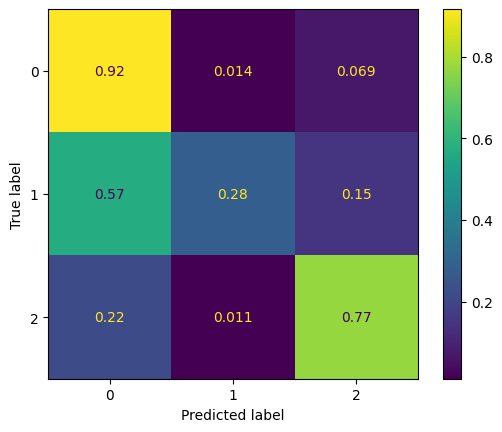

In [77]:
y_true = dev_Y 
y_pred = prediccion_Yprima
confusion_matrix(y_true, y_pred)
cm= confusion_matrix(y_true, y_pred, normalize= 'true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [79]:
# Ahora entreno con todos los datos de train.

clf.fit(trainingX[joined_list],trainingY) 
prediccion = clf.predict(testX[joined_list])

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   48.5s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:  1.7min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.3s finished


In [80]:
#Realizamos nuestra predicción. 
pd.Series(prediccion).value_counts()

0    9169
2    5208
1     473
Name: count, dtype: int64

In [81]:
#Faltaria guardar predicción en un csv y subirlo a la web. Pero primero transformamos los números a su etiqueta original.
#El csv tiene que tener 2 columnas, el id y el status (etiqueta/clase).

submission_df = pd.DataFrame({
    "id": testX["id"],
    "status_group": prediccion
})
submission_df['status_group'].replace([0, 1, 2], ['functional','functional needs repair','non functional'], inplace= True) 
submission_df.to_csv("submission.csv", index=False)

C:\Users\Aisha Aman\AppData\Local\Temp\ipykernel_12660\2628230998.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  submission_df['status_group'].replace([0, 1, 2], ['functional','functional needs repair','non functional'], inplace= True)


La puntuación obtenida en la competición con los resultados del anterior modelo es 0,8188. Hemos realizado 17 submissions.

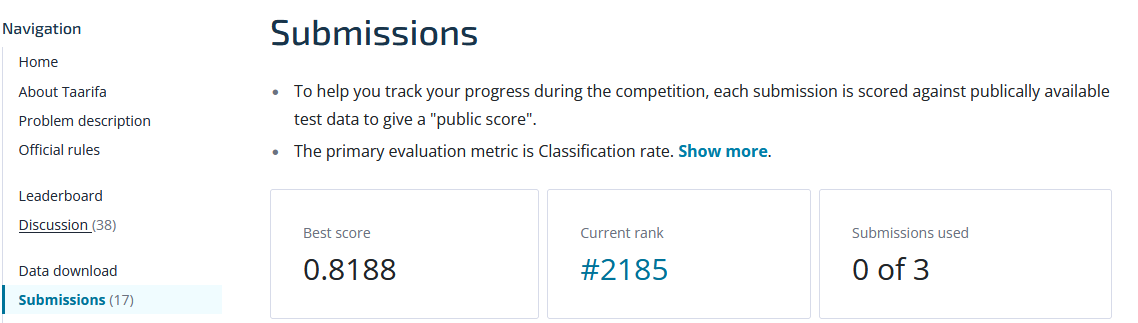

**Además para mayor información adjunto el resumen de todas las tecnicas que he probado, modificación de hiperparametros y cambios realizados a lo largo del analisis**

Inicialmente empezamos a trabajar con modelos sencillos y unas pocas columnas que no tenian complicación, por ello las primeras subidas tenian un score bajo. Luego fuimos añadiendo columnas y mejorando el preprocesado y utilice modelos mas avanzados.

clf = MLPClassifier(random_state=1, max_iter=50, hidden_layer_sizes=(100,20),early_stopping=True)
0.7521885521885522

clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=5, random_state=0, verbose=True)
0.782070707070707

clf = GradientBoostingClassifier(n_estimators=80, learning_rate=0.1, max_depth=10, random_state=0, verbose=True)
0.8026936026936027
train los+s: 0.3131

clf = GradientBoostingClassifier(n_estimators=80, learning_rate=0.1, max_depth=20, random_state=0, verbose=True)
0.7986531986531986
train loss: 0.0236

clf = GradientBoostingClassifier(n_estimators=90, learning_rate=0.05, max_depth=15, random_state=0, verbose=True)
0.805050505050505
train loss: 0.1540

sobre el train x:
loss:0.1672

functional                 8938
non functional             5235
functional needs repair     677



categorical_columns = ['extraction_type', 'management', 'water_quality', 'quantity','quantity_group', 
          'source', 'waterpoint_type', 'extraction_type_group','payment','payment_type', 'source_type' ] 

clf = GradientBoostingClassifier(n_estimators=90, learning_rate=0.05, max_depth=10, random_state=0, verbose=True)
loss: 0.3755
0.7937710437710438

clf = GradientBoostingClassifier(n_estimators=90, learning_rate=0.05, max_depth=15, random_state=0, verbose=True)
loss:0.1589
0.8015151515151515


categorical_columns = ['extraction_type', 'management', 'water_quality' , 'quality_group', 'quantity','quantity_group', 
          'source','source_class', 'waterpoint_type','waterpoint_type_group', 'extraction_type_group',
                       'extraction_type_class','management_group','payment','payment_type', 'source_type','basin','region']
 
columnas = ['amount_tsh', 'gps_height', 'longitude', 'latitude','date_numeric', 'construction_year', 'population']

clf = GradientBoostingClassifier(n_estimators=90, learning_rate=0.05, max_depth=15, random_state=0, verbose=True)
loss:0.1506 
0.8063131313131313



categorical_columns = ['extraction_type', 'management', 'water_quality' , 'quality_group', 'quantity','quantity_group', 
          'source','source_class', 'waterpoint_type','waterpoint_type_group', 'extraction_type_group',
                       'extraction_type_class','management_group','payment','payment_type', 'source_type','basin','region']
 
columnas = ['amount_tsh', 'gps_height', 'longitude', 'latitude','date_numeric', 'construction_year', 'population']

clf = GradientBoostingClassifier(n_estimators=90, learning_rate=0.05, max_depth=15, random_state=0, verbose=True)

loss:0.154
0.8017676767676768


categorical_columns= ['extraction_type', 'management', 'water_quality' , 'quality_group', 'quantity','quantity_group', 
          'source','source_class', 'waterpoint_type','waterpoint_type_group', 'extraction_type_group',
                       'extraction_type_class','management_group','payment','payment_type', 'source_type','basin','region']

columnas= ['amount_tsh', 'gps_height', 'longitude', 'latitude','date_numeric', 'construction_year', 'population']

loss: 0.1348
0.8062289562289562

categorical_columns y columnas son iguales
clf = GradientBoostingClassifier(n_estimators=150, learning_rate=0.05, max_depth=15, random_state=0, verbose=True)
loss:0.1408
0.805050505050505

clf = RandomForestClassifier(max_depth=20, random_state=0,verbose=True, n_estimators=100)
0.8075757575757576

clf = RandomForestClassifier(max_depth=20, random_state=0,verbose=True, n_estimators=150)
0.7993265993265993

clf = RandomForestClassifier(max_depth=25, random_state=0,verbose=True, n_estimators=100)
0.8062289562289562

clf = RandomForestClassifier(max_depth=20, random_state=0,verbose=True, n_estimators=50)
0.8069023569023569

clf = RandomForestClassifier(max_depth=20, random_state=0,verbose=True, n_estimators=125)
0.7984006734006734

clf = RandomForestClassifier(random_state=0,verbose=True, n_estimators=100, max_depth=23,min_samples_leaf=5, max_features=15)
0.7968855218855219

clf = RandomForestClassifier(random_state=0,verbose=True, n_estimators=100, max_depth=23,min_samples_leaf=5, max_features=30) 
0.8093434343434344

clf = RandomForestClassifier(random_state=0,verbose=True, n_estimators=100, max_depth=23,min_samples_leaf=5, max_features=35)
0.8101010101010101
optimo: max_features 35

clf = RandomForestClassifier(random_state=0,verbose=True, n_estimators=100, max_depth=23,min_samples_leaf=5, max_features=40)
0.8095959595959596

clf = RandomForestClassifier(random_state=0,verbose=True, n_estimators=100, max_depth=24,min_samples_leaf=5, max_features=35)
no lo copie pero es peor

clf = RandomForestClassifier(random_state=0,verbose=True, n_estimators=100, max_depth=22,min_samples_leaf=5, max_features=35)
0.8089225589225589

clf = RandomForestClassifier(random_state=0,verbose=True, n_estimators=120, max_depth=23,min_samples_leaf=5, max_features=35)
0.8092592592592592

clf = RandomForestClassifier(random_state=0,verbose=True, n_estimators=105, max_depth=23,min_samples_leaf=5, max_features=35)
0.8095117845117845

clf = RandomForestClassifier(random_state=0,verbose=True, n_estimators=100, max_depth=23,min_samples_leaf=6, max_features=35)
0.8061447811447812

clf = RandomForestClassifier(random_state=0,verbose=True, n_estimators=100, max_depth=23,min_samples_leaf=5, max_features=35)
0.809006734006734


historico (antes de 05/03/24):
categorical_columns = ['extraction_type', 'management', 'water_quality' , 'quality_group', 'quantity','quantity_group', 
          'source','source_class', 'waterpoint_type','waterpoint_type_group', 'extraction_type_group',
                       'extraction_type_class','management_group','payment','payment_type', 'source_type' ] 

06/03/24:
categorical_columns = ['extraction_type', 'management', 'water_quality' , 'quality_group', 'quantity','quantity_group', 
          'source','source_class', 'waterpoint_type','waterpoint_type_group', 'extraction_type_group',
                       'extraction_type_class','management_group','payment','payment_type', 'source_type','basin','region'] 
columnas = ['amount_tsh', 'gps_height', 'longitude', 'latitude','date_numeric', 'construction_year', 'population']
clf = HistGradientBoostingClassifier(categorical_features=categorical_columns, verbose=True, max_iter=300)
0.8062289562289562


añadi district_code:
0.8045454545454546

wpt_name, funder, installer, wpt_name, subvillage, ward, scheme_name,--> mas de 255 cardinality 


añadi lga:
0.8056397306397306

añadi public_meeting:
0.8094276094276094

añadi scheme_management:
0.809006734006734

10/03: reemplazar subvillage por su frecuencia (valuecounts)
0.8015151515151515


grouping rare cathegories de subvillage:
0.80993265993266

grouping rare cathegories de subvillage, installer:
0.8045454545454546

clf = HistGradientBoostingClassifier(categorical_features=categorical_columns, verbose=True, max_iter=600,n_iter_no_change=30)
0.8101851851851852----competicion: 0.8147

clf = HistGradientBoostingClassifier(categorical_features=categorical_columns, verbose=True, max_iter=600,n_iter_no_change=30, max_depth=None,
                                     validation_fraction=0.05)
0.8068181818181818



clf = HistGradientBoostingClassifier(categorical_features=categorical_columns, verbose=True, max_iter=600,n_iter_no_change=30, max_depth=15)
0.8095117845117845

clf = HistGradientBoostingClassifier(categorical_features=categorical_columns, verbose=True, max_iter=600,n_iter_no_change=30, max_depth=None,
                                     validation_fraction=0.01)
0.8143939393939394-----competicion: 0.8131


clf = HistGradientBoostingClassifier(categorical_features=categorical_columns, verbose=True, max_iter=600,n_iter_no_change=30, max_depth=None,
                                     validation_fraction=0.1)
clf anterior + grouping rare cathegories de subvillage, installer, ward:
0.8082491582491582

clf anterior +
quitar ward de cathegorical, aumentar categorias:
0.8051346801346801


clf = HistGradientBoostingClassifier(categorical_features=categorical_columns, verbose=True, max_iter=600,n_iter_no_change=30, max_depth=None,
                                     validation_fraction=0.1, random_state=1)
añadimos grupo raro scheme_name:
0.8104377104377104

quitamos scheme_name y con clf clf = HistGradientBoostingClassifier(categorical_features=categorical_columns, verbose=True, max_iter=600,n_iter_no_change=30, max_depth=None,
                                     validation_fraction=0.1, random_state=1)
0.8112794612794613


clf = HistGradientBoostingClassifier(categorical_features=categorical_columns, verbose=True, max_iter=600,n_iter_no_change=30, max_depth=None,
                                     validation_fraction=0.1, random_state=1, l2_regularization=0.5)
0.812037037037037


clf = HistGradientBoostingClassifier(categorical_features=categorical_columns, verbose=True, max_iter=600,n_iter_no_change=30, max_depth=None,
                                     validation_fraction=0.1, random_state=1, l2_regularization=5
)




11/03:

clf1 = HistGradientBoostingClassifier(categorical_features=categorical_columns, verbose=True, max_iter=600,n_iter_no_change=30, max_depth=None,
                                    validation_fraction=0.1, random_state=1)
clf2 = XGBClassifier(n_estimators=350,objective='multi:softprob',random_state=55,tree_method="hist", enable_categorical=True, n_jobs=4)

clf = VotingClassifier(estimators=[('sk', clf1), ('xgb', clf2)], voting='soft')

0.8146464646464646----competicion: 0.8157

13/03:
sustituir 0 (valores que faltan) en variables numericas por su media de cada columna:
0.8143939393939394

anterior + sustituir valores vacios en categorial_columns por moda:
0.8143939393939394----competicion: 0.8158 

anterior +  RandomForestClassifier(random_state=55,verbose=True, n_estimators=100, max_depth=23,min_samples_leaf=5, max_features=35)
0.8078282828282828


HistGradient + XGB + RandomForest:
0.8151515151515152 -------------------> competicion: 0.8188

anterior+hard:

clf1 = HistGradientBoostingClassifier(categorical_features=categorical_columns, verbose=False, max_iter=600,n_iter_no_change=30, max_depth=None,
                                    validation_fraction=0.1, random_state=1)

clf2 = XGBClassifier(n_estimators=350,objective='multi:softprob',random_state=55,tree_method="hist", enable_categorical=True, n_jobs=4)

transfomer = make_column_transformer((FunctionTransformer(lambda x: x), columnas), (OneHotEncoder(), categorical_columns))

clf3 = make_pipeline(transfomer, RandomForestClassifier(random_state=55,verbose=True, n_estimators=100,
                                                        max_depth=23,min_samples_leaf=5, max_features=35, n_jobs=2))

clf = VotingClassifier(estimators=[('skgb', clf1), ('xgb', clf2), ('rf', clf3)], voting='hard')

0.8125420875420876 --------------------->competicion: 0.8170 


14/03: 
cambie clf3 n_estimators=150

0.8151515151515152


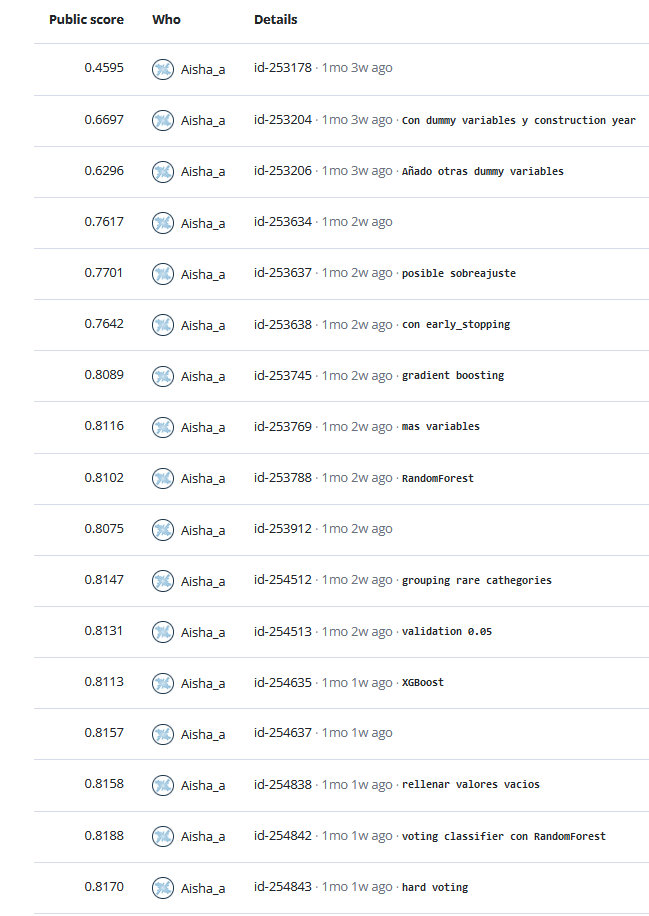